## Importing necessary libraries

In [ ]:
# Data Manipulation and Visualization
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# PyTorch, Torchvision, and vision related libraries
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision
import torch_optimizer as tor_optim
from torch.optim import Adam, RMSprop, SGD
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, shufflenetv2

# OpenCV, Pillow, SKImage, Albumentations
import cv2
import PIL
import albumentations as al
from albumentations.pytorch import ToTensorV2
from PIL import Image
from skimage import io

# Logging and inbuilt libraries
import wandb # weights and biases library
import pickle
import random, os, sys, logging
import ipywidgets as widgets
from tqdm import tqdm
from ipywidgets import interact,interactive,interact_manual
import warnings
warnings.filterwarnings("ignore")

logging.propagate = False
logging.getLogger().setLevel(logging.ERROR)


## Reading Images

In [ ]:
# Specify the folder names required for generating paths below
train_good = ['images', 'train', 'good']
train_bad  = ['images', 'train', 'bad']
test_good  = ['images', 'test', 'good']
test_bad   = ['images', 'test', 'bad']

In [ ]:
# Generate required paths for the train and test folders
owd = os.getcwd()
train_good = os.path.join(owd,*train_good)
train_bad  = os.path.join(owd,*train_bad)
test_good  = os.path.join(owd,*test_good)
test_bad   = os.path.join(owd,*test_bad)

print(f'Train Good Images Directory: {train_good}')
print(f'Train Bad Images Directory: {train_bad}')
print(f'Test Good Images Directory: {test_good}')
print(f'Test Bad Images Directory: {test_bad}')

In [ ]:
for infile in os.listdir(train_good):
    print(infile)

In [ ]:
for infile in os.listdir(train_bad):
    print(infile)

In [ ]:
for infile in os.listdir(test_good):
    print(infile)

In [ ]:
for infile in os.listdir(test_bad):
    im = Image.open(os.path.join(test_bad,infile))
    #im.show()
    print(infile)
    

## Image Pre-Processing and Augmentation

In [ ]:
# Resizing Images
HEIGHT = 128
WIDTH  = 128

In [ ]:
# Defining Transformations required for augmenting the images
transform = al.Compose([
            al.Resize(width=WIDTH, height=HEIGHT,p=1.0),
    
            al.Rotate(limit=90, p=1.0),
    
            al.HorizontalFlip(p=0.3),
    
            al.VerticalFlip(p=0.2),
    
            al.ColorJitter(contrast=2, p=0.2),
    
            al.ColorJitter(brightness=2, p=0.2),
    
            al.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            p=1.0),
])

In [ ]:
# Augmented Images Directories
aug_train_good = 'C:/Users/abhij/OneDrive - Indiana University/3rd Semester/Intro to Intelligent Systems/Project/images/aug_train/good'
aug_train_bad  = 'C:/Users/abhij/OneDrive - Indiana University/3rd Semester/Intro to Intelligent Systems/Project/images/aug_train/bad'

In [ ]:
def augment(IMG_DIR, AUG_PATH_IMAGE, num):
    print("*******************Augmentation Started*****************************")
    for i, infile in enumerate(os.listdir(IMG_DIR)):
        image = cv2.imread(os.path.join(IMG_DIR,infile))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for j in range(num):
            transformed = transform(image=image)
            transformed_image = transformed['image']
            transformed_image = transformed_image*255
            transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)
            fname = AUG_PATH_IMAGE + '/' + infile[:-4]+ '_'+str(j)+'.jpg'
            cv2.imwrite(fname, transformed_image)
    print()
    print("*******************Augmentation Finished*****************************")

In [ ]:
augment(train_good, aug_train_good, 30)

In [ ]:
augment(train_bad, aug_train_bad, 125)

In [ ]:
# Creating a csv file for train data to generate labels for all the good and bad images

# labels_traindf = pd.DataFrame()

# arr_img_tr = []
# arr_lab_tr = []
# for i in os.listdir(aug_train_good):
#     arr_img_tr.append(i)
#     arr_lab_tr.append(1)

# for i in os.listdir(aug_train_bad):
#     arr_img_tr.append(i)
#     arr_lab_tr.append(0)
    
# labels_traindf['Image_fnames'] = arr_img_tr
# labels_traindf['labels']       = arr_lab_tr
# labels_traindf.to_csv('train.csv', index=False)

In [ ]:
# Creating a csv file for test data to generate labels for all the good and bad images

# labels_testdf  = pd.DataFrame()

# arr_img_te = []
# arr_lab_te = []
# for i in os.listdir(test_good):
#     arr_img_te.append(i)
#     arr_lab_te.append(1)

# for i in os.listdir(test_bad):
#     arr_img_te.append(i)
#     arr_lab_te.append(0)
    
# labels_testdf['Image_fnames'] = arr_img_te
# labels_testdf['labels']       = arr_lab_te
# labels_testdf.to_csv('test.csv', index=False)

In [ ]:
# Creating a Dataset class 
# class WeldDataset(Dataset):
#     def __init__(self, csv_file, root_dir, transform=None):
#         self.annotations = pd.read_csv(csv_file)
#         self.root_dir    = root_dir
#         self.transform   = transform
        
#     def __len__(self):
#         return len(self.annotations)   # train_set -> 8930, test_set -> 30
        
#     # Return a specific image and corresponding label to that image
#     def __getitem__(self, index):
#         # Index -> we don't have to choose it, PyTorch does it for us
#         img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
#         image    = io.imread(img_path)
#         y_label  = torch.tensor(int(self.annotations.iloc[index, 1]))
        
#         if self.transform:
#             image = self.tranform(image)
            
#         return (image, ylabel)   # returns 1 image and 1 corresponding label to that image

In [ ]:
# Loading the data
# train_dataset = WeldDataset(csv_file = 'train.csv', root_dir = 'train_set', transform = train_transform)
# test_dataset  = WeldDataset(csv_file = 'test.csv', root_dir = 'test_set', transform = test_transform)

# train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)
# test_loader  = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=True)

In [ ]:
# Defining classes related to weld defects
classes = ['bad', 'good']

for labels in enumerate(classes):
    print(labels)

In [ ]:
# Defining final transformation to be applied to train and test images for creating dataloaders
# Normalization values are specific to the ResNet models, because ResNet models have been pre-trained on these values

train_transform = transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

#### Hyperparameters

In [ ]:
# Initializing the values
in_channel    = 3
num_classes   = 2
learning_rate = 0.01
batch_size    = 32
num_epochs    = 20

#### Loading Datasets and Creating DataLoaders

## ResNet 50 with Adam Optimizer

In [ ]:
# Setting the device as gpu or cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
# Loading pre-trained ResNet 50 model
model = resnet50(pretrained = True)

In [ ]:
# Chaning the output layer of the resnet 50 model
model.fc = nn.Linear(in_features=2048, out_features=2)
model = model.to(device)

In [ ]:
# Checking if the model is on cuda/gpu or not
next(model.parameters()).is_cuda

#### Optimizer and Loss Function

In [ ]:
# Initializing Optimizer
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Initializing Loss Function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# os.environ['CUDA_VISIBLE_DEVICES']='2, 3'

#### Training and Evaluate the Model

In [ ]:
def train_model(model):
    train_loss     = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(train_loader, unit='batch') as te:
            for i, (image, label) in enumerate(te):
                image = image.to(device)
                label = label.to(device)

                pred = model(image)

                loss = loss_fn(pred, label)

                # train_prob = train_prob.cpu() # Assigining train_probabilites to cpu to prevent maxing out of CUDA memory
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
                if i % 70 == 69:    # print and store every 70 mini-batches: 4 times per epoch
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 70:.3f}')
                    train_loss.append(running_loss / 70)
                    
                    running_loss = 0.0
                    
    return model, train_loss

In [ ]:
def test_model(model):
    with torch.no_grad():
        correct = 0
        total = 0
        for test_image, test_label in test_loader:
            test_image = test_image.to(device)
            test_label = test_label.to(device)
            test_prob  = model(test_image)
            # test_prob  = test_prob.cpu() 

            test_pred  = torch.max(test_prob, 1).indices
    #         print(test_label, test_pred)
    #         test_acc   += int(torch.sum(test_pred == test_label))
            total += test_label.size(0)
            correct += (test_pred == test_label).sum().item()

        #ep_test_acc = test_acc / len(test_loader)

        print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [ ]:
resnet_adam, train_loss_adam = train_model(model)

In [ ]:
test_model(resnet_adam)

In [ ]:
# Train Loss v Test Accuracy Plot_ResNet50_Adam
plt.figure(figsize=(10,6))
plt.plot(train_loss_adam, color='r')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Train Loss ResNet 50_Adam Optimizer')
plt.show()

#### Saving Model

In [ ]:
# Saving ResNet50 model with Adam optimizer
torch.save(model.state_dict(), os.path.join(owd, 'ResNet50_Adam.pth'))

#### Loading Model

In [ ]:
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model

## ResNet 50 -> SGD with Momentum Optimizer

In [ ]:
def train_model(model):
    train_loss     = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(train_loader, unit='batch') as te:
            for i, (image, label) in enumerate(te):
                image = image.to(device)
                label = label.to(device)

                pred = model(image)

                loss = loss_fn(pred, label)

                # train_prob = train_prob.cpu() # Assigining train_probabilites to cpu to prevent maxing out of CUDA memory
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
                if i % 70 == 69:    # print and store every 70 mini-batches: 4 times per epoch
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 70:.3f}')
                    train_loss.append(running_loss / 70)
                    
                    running_loss = 0.0
                    
    return model, train_loss

In [ ]:
def test_model(model):
    with torch.no_grad():
        correct = 0
        total = 0
        for test_image, test_label in test_loader:
            test_image = test_image.to(device)
            test_label = test_label.to(device)
            test_prob  = model(test_image)
            # test_prob  = test_prob.cpu() 

            test_pred  = torch.max(test_prob, 1).indices
    #         print(test_label, test_pred)
    #         test_acc   += int(torch.sum(test_pred == test_label))
            total += test_label.size(0)
            correct += (test_pred == test_label).sum().item()

        #ep_test_acc = test_acc / len(test_loader)

        print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [ ]:
model = resnet50(pretrained = True)
model.fc = nn.Linear(in_features=2048, out_features=2)
model = model.to(device)

# Initializing Optimizer
optimizer = SGD(model.parameters(), momentum = 0.5, lr=learning_rate, weight_decay=0.0001)

# Initializing Loss Function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
resnet_sgd, train_loss_sgd = train_model(model)

In [ ]:
test_model(resnet_sgd)

In [ ]:
# Train Loss v Test Accuracy Plot_SGD with Momentum
plt.figure(figsize=(8,5))
plt.plot(train_loss_sgd, color='r')
plt.xlabel('Epochs')
plt.ylabel('training loss')
plt.title('Train Loss ResNet 50_SGD Optimizer with Momentum')
plt.show()

In [ ]:
# Saving ResNet50 model -> SGD Optimizer with momentum
torch.save(resnet_sgd.state_dict(), os.path.join(owd, 'ResNet50_SGD_Momentum.pth'))

## ResNet 50 -> RMSProp Optimizer

In [ ]:
model_rms = resnet50(pretrained = True)
model_rms.fc = nn.Linear(in_features=2048, out_features=2)
model_rms = model_rms.to(device)

# Initializing Optimizer
optimizer = RMSprop(model_rms.parameters(), lr=0.01)

# Initializing Loss Function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
resnet_prop, train_loss_rms = train_model(model_rms)

In [ ]:
test_model(resnet_prop)

In [ ]:
# Train Loss v Test Accuracy Plot_RMSprop Optimizer
plt.figure(figsize=(14,8))
plt.plot(train_loss_rms, color='r')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Train Loss with ResNet 50 and RMSprop Optimizer')
plt.show()

In [ ]:
# Saving ResNet50 model -> _RMSprop Optimizer
torch.save(resnet_prop.state_dict(), os.path.join(owd, 'ResNet50__RMSprop.pth'))

## ResNet 50 -> AdaBound Optimizer

In [ ]:
model = resnet50(pretrained = True)
model.fc = nn.Linear(in_features=2048, out_features=2)
model = model.to(device)

# Initializing Optimizer
optimizer = tor_optim.AdaBound(
    model.parameters(),
    lr= 1e-3,
    betas= (0.9, 0.999),
    final_lr = 0.1,
    gamma=1e-3,
    eps= 1e-8,
    weight_decay=0,
    amsbound=False,
)

# Initializing Loss Function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
resnet_adb, train_loss_adb= train_model(model)

In [ ]:
# # Train Loss v Test Accuracy Plot_AdaBound
# plt.figure(figsize=(14,8))
# plt.plot(train_loss_adb,'-o', color='r')
# plt.plot(test_acc_adb,'-o', color='g')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy_Loss')
# plt.legend(['Train Loss','Test Accuracy'])
# plt.title('Train Loss vs Test Accuracy Plot_ResNet 50_AdaBound Optimizer')
# plt.show()

In [ ]:
# Saving ResNet50 model -> AdaBound Optimizer
torch.save(model.state_dict(), os.path.join(owd, 'ResNet50__AdaBound.pth'))

## ShuffleNet v2 with AdaBound Optimizer

In [ ]:
# Loading pre-trained ShuffleNet v2 model
shufflenet = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)

In [ ]:
# Chaning the output layer of the shufflenet v2 model
shufflenet.fc = nn.Linear(in_features=1024, out_features=2)
shufflenet = shufflenet.to(device)

In [ ]:
# Initializing Optimizer
optimizer = tor_optim.AdaBound(
    shufflenet.parameters(),
    lr= 1e-3,
    betas= (0.9, 0.999),
    final_lr = 0.1,
    gamma=1e-3,
    eps= 1e-8,
    weight_decay=0,
    amsbound=False,
)

# Initializing Loss Function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
shuffle_adb, train_loss_adb = train_model(shufflenet)

In [ ]:
test_model(shuffle_adb)

In [ ]:
# Train Loss v Test Accuracy Plot_AdaBound
plt.figure(figsize=(14,8))
plt.plot(train_loss_adb, color='r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy_Loss')
plt.legend(['Train Loss','Test Accuracy'])
plt.title('Train Loss vs Test Accuracy Plot_ShuffleNet v2_AdaBound Optimizer')
plt.show()

In [ ]:
# Saving ShuffleNet v2 model -> AdaBound Optimizer
torch.save(shuffle_adb.state_dict(), os.path.join(owd, 'ShuffleNet v2__AdaBound.pth'))

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(train_loss_adam, color='r')
plt.plot(train_loss_sgd, color='blue')
plt.plot(train_loss_rms, color='g')
plt.plot(train_loss_adb, color='black')
plt.xlabel('Epochs')
plt.ylabel('Accuracy_Loss')
plt.legend(['resnet_adam','resnet_sgd_momentum', 'resnet_RMSProp','shufflenet_AdaBound'])
plt.title('training loss comparison')
plt.show()


In [40]:
test_model(shuffle_adb)

Accuracy of the network on the test images: 96 %


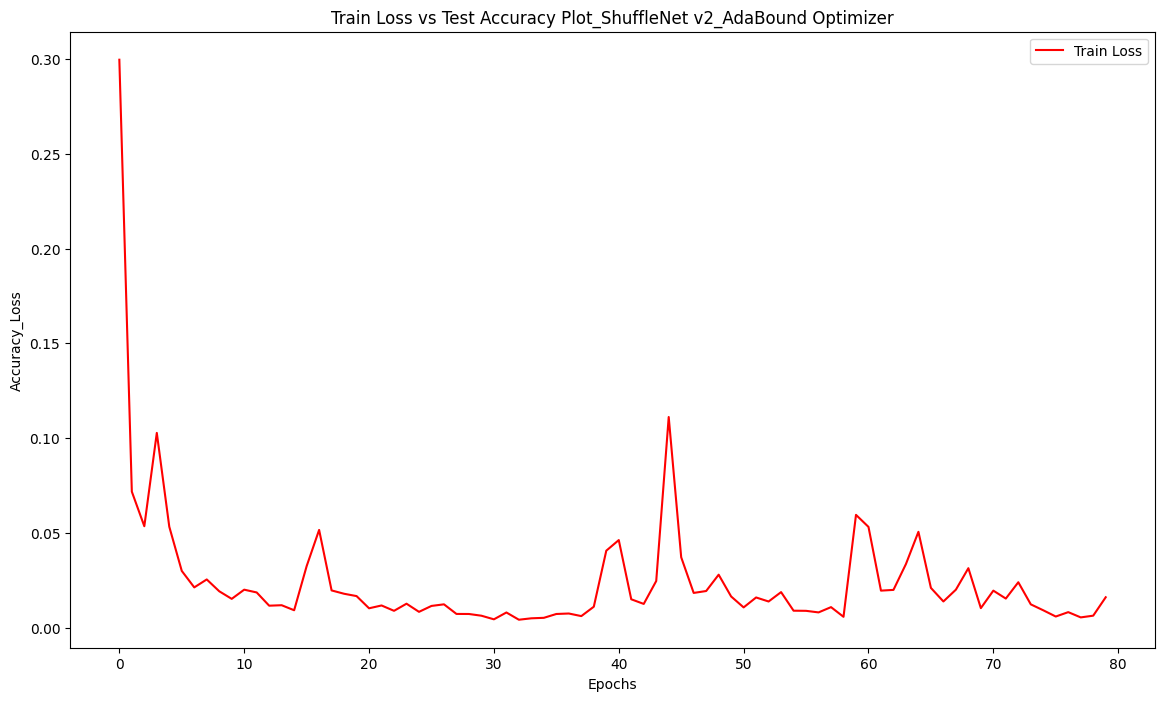

In [41]:
# Train Loss v Test Accuracy Plot_AdaBound
plt.figure(figsize=(14,8))
plt.plot(train_loss_adb, color='r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy_Loss')
plt.legend(['Train Loss','Test Accuracy'])
plt.title('Train Loss vs Test Accuracy Plot_ShuffleNet v2_AdaBound Optimizer')
plt.show()

In [118]:
# Saving ShuffleNet v2 model -> AdaBound Optimizer
torch.save(shuffle_adb.state_dict(), os.path.join(owd, 'ShuffleNet v2__AdaBound.pth'))

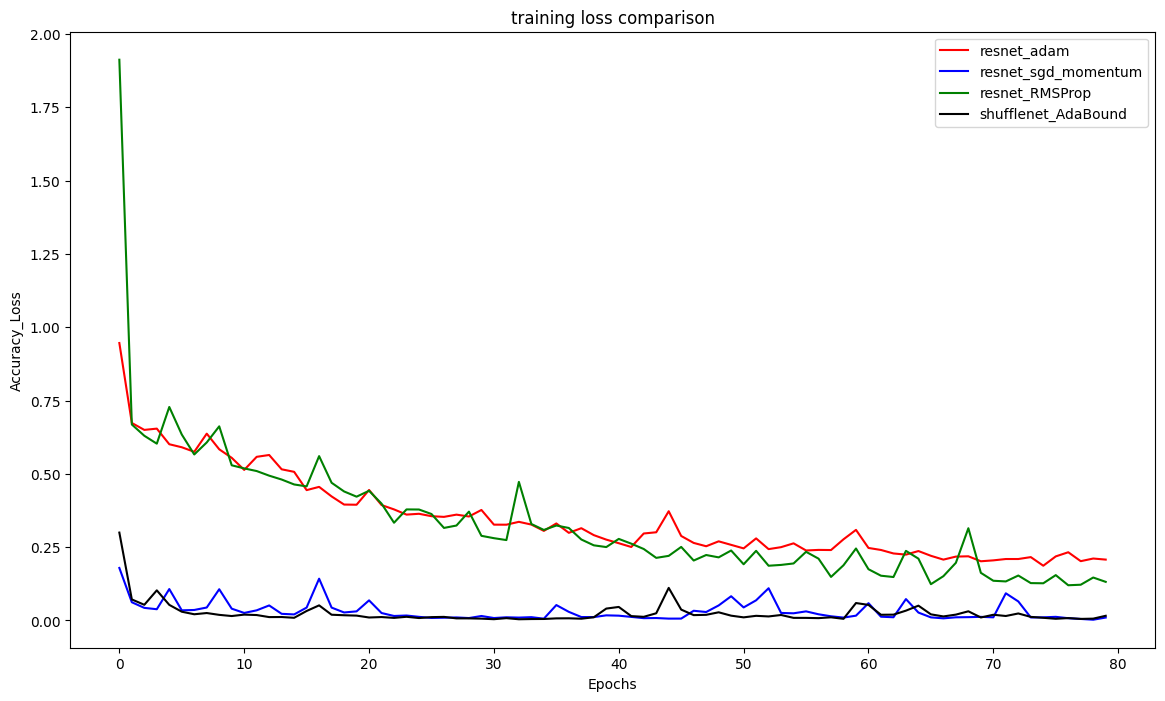

In [42]:
plt.figure(figsize=(14,8))
plt.plot(train_loss_adam, color='r')
plt.plot(train_loss_sgd, color='blue')
plt.plot(train_loss_rms, color='g')
plt.plot(train_loss_adb, color='black')
plt.xlabel('Epochs')
plt.ylabel('Accuracy_Loss')
plt.legend(['resnet_adam','resnet_sgd_momentum', 'resnet_RMSProp','shufflenet_AdaBound'])
plt.title('training loss comparison')
plt.show()
